In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [2]:
def qobj_round(qobj, digits=2):
    data = np.round(qobj.full(), digits)
    return Qobj(data, dims=qobj.dims)

In [14]:
def create_shallow_pocket_model(g, r, t, T):
    """
    Construct the Choi state of the superchannel for the shallow-pocket model.

    Parameters
    ----------
    g : float
        Coupling strength between the system and the environment.
    r : float
        Lorentzian width parameter (> 0) for the environment's initial state in position space:
            |psi(x)|^2 = (r/pi) * 1/(x^2 + r^2),
        equivalently
            <x|psi> = sqrt(r/pi) * 1/(x + i*r).
    t : float
        Evolution time for the "history" segment.
    T : float
        Evolution time for the "future" segment.

    Returns
    -------
    qutip.Qobj
        Choi state (as a Qobj) representing the superchannel in the shallow-pocket model.
    """
    
    # Define basis states for 4-qubit system
    ket_0000 = basis(16, 0)   # |0000⟩
    ket_0011 = basis(16, 3)   # |0011⟩
    ket_1100 = basis(16, 12)  # |1100⟩
    ket_1111 = basis(16, 15)  # |1111⟩
    
    # Calculate exponential terms with g*gamma*t
    grt = g * gamma * t
    exp_neg_grt = np.exp(-g*r*t)                # e^(-grt)
    exp_neg_grT = np.exp(-g*r*T)                # e^(-grT)
    exp_neg_grtplusT = np.exp(-g*r * (t + T))  # e^(-gr(t+T))
    exp_neg_grtminusT = np.exp(-g*r * np.abs(t - T)) # e^(-gr|(t-T)|)
    
    # Build operator using QuTiP's ket-bra notation
    I = (ket_0000 * ket_0000.dag() + 
         exp_neg_grT * ket_0011 * ket_0000.dag() + 
         exp_neg_grt * ket_1100 * ket_0000.dag() + 
         exp_neg_grtplusT * ket_1111 * ket_0000.dag() +
         
         exp_neg_grT * ket_0000 * ket_0011.dag() + 
         ket_0011 * ket_0011.dag() + 
         exp_neg_grtminusT * ket_1100 * ket_0011.dag() + 
         exp_neg_grt * ket_1111 * ket_0011.dag() +
         
         exp_neg_grt * ket_0000 * ket_1100.dag() + 
         exp_neg_grtminusT * ket_0011 * ket_1100.dag() + 
         ket_1100 * ket_1100.dag() + 
         exp_neg_grT * ket_1111 * ket_1100.dag() +
         
         exp_neg_grtplusT * ket_0000 * ket_1111.dag() + 
         exp_neg_grt * ket_0011 * ket_1111.dag() + 
         exp_neg_grT * ket_1100 * ket_1111.dag() + 
         ket_1111 * ket_1111.dag())

    I.dims = [[2, 2, 2, 2], [2, 2, 2, 2]]
    
    return I

Choi state of a superchannel for the shallow-pocket model:

Dimensions: [[2, 2, 2, 2], [2, 2, 2, 2]]
Shape: (16, 16)
Is Hermitian: True
Positive semidefinite: True

Partial traces:
ptrace([1,2,3]):
Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1.  0.  0.  0.3 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.3 0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.3]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.3 0.  0.  1. ]]

ptrace([3]):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[2. 0.]
 [0. 2.]]


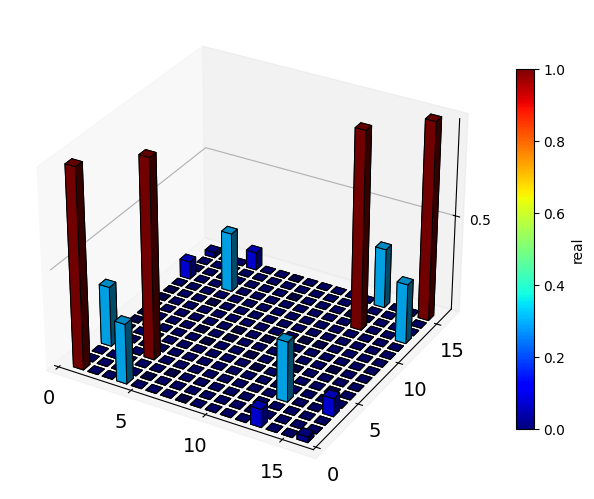

In [19]:
# Example usage
g = 0.8
gamma = 0.3
t = 10
T = 5

choi_superchannel = create_shallow_pocket_model(g, gamma, t, T)

print("Choi state of a superchannel for the shallow-pocket model:")
print(f"\nDimensions: {choi_superchannel.dims}")
print(f"Shape: {choi_superchannel.shape}")
print(f"Is Hermitian: {choi_superchannel.isherm}")

# Check generalised complete positivity and trace preservation
print(f"Positive semidefinite: {np.all(np.min(choi_superchannel.eigenenergies()) >= -1e-10)}")
print("\nPartial traces:")
print("ptrace([1,2,3]):")
print(qobj_round(choi_superchannel.ptrace([1,2,3]),2))
print("\nptrace([3]):")
print(choi_superchannel.ptrace([3]))

# Visualize the matrix
fig, ax = matrix_histogram(choi_superchannel)

ticks = [0, 5, 10, 15]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

plt.show()    

In [20]:
def link_product(superchannel, input_channel):
    """
    Link product of superchannel and input channel gives the output channel.
    Superchannel shape is H_3 ⊗ H_2 ⊗ H_1 ⊗ H_0
    Input channel shape is H_2 ⊗ H_1
    Space they both act upon is H_2 ⊗ H_1
    """
    return (tensor(qeye(2), input_channel, qeye(2)).trans().trans() * superchannel).ptrace([3,0]) 

def choi_state_unitary(v):
    """
    Creates the choi state of an unitary v.
    
    The Choi state is defined as:
    J(Φ) = (Φ ⊗ I)(|Φ+⟩⟨Φ+|)
    where |Φ+⟩ = (|00⟩ + |11⟩) is the maximally entangled state.
    
    Returns
    -------
    qutip.Qobj
        Choi state (4x4 matrix with dims [[2,2],[2,2]])
    """
    # Create the maximally entangled state |Φ+⟩ = (|00⟩ + |11⟩)/√2
    ket_00 = tensor(basis(2, 0), basis(2, 0))
    ket_11 = tensor(basis(2, 1), basis(2, 1))
    phi_plus = (ket_00 + ket_11)

    choi = tensor(v, qeye(2)) * phi_plus
    choi = choi * choi.dag()

    choi.dims = [[2, 2], [2, 2]]
    
    return choi    

In [21]:
# Example usage

# Choi state of Pauli X (NOT gate)
print(f"Pauli X operator:\n{sigmax()}")
choi_x = choi_state_unitary(sigmax())
print(f"\nInput_channel:\n{choi_x}")

choi_output = link_product(choi_superchannel, choi_x)
print(f"\nOutput Channel:\n{choi_output}")

Pauli X operator:
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

Input_channel:
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]]

Output Channel:
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         1.         0.30119421 0.        ]
 [0.         0.30119421 1.         0.        ]
 [0.         0.         0.         0.        ]]


In [7]:
def parameterised_unitary(theta, phi, psi):
    """
    Creates a unitary given three angles: 
    V = rz(psi)ry(phi)rz(theta),
    where rz and ry are rotation operators around z axis and y axis, respectively.
    """
    return rz(psi)*ry(phi)*rz(theta)

def rz(theta):
    """
    Returns a z-axis rotation operator given theta
    """
    return (-1j*theta/2*sigmaz()).expm()

def ry(phi):
    """
    Returns a y-axis rotation operator given phi
    """
    return (-1j*phi/2*sigmay()).expm()

In [8]:
# Example usage
theta = np.pi
phi = np.pi/7
psi = np.pi

v = parameterised_unitary(theta, phi, psi)

# Choi state of V
print(f"Unitary V({theta:.2f}, {phi:.2f}, {psi:.2f}):")
print(qobj_round(v, 2))

choi_input = choi_state_unitary(v)
print("\nInput channel:")
print(qobj_round(choi_input, 2))

choi_output = link_product(choi_superchannel, choi_input)
print("\nOutput channel:")
print(qobj_round(choi_output, 2))

Unitary V(3.14, 0.45, 3.14):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-0.97 -0.22]
 [ 0.22 -0.97]]

Input channel:
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.95  0.22 -0.22  0.95]
 [ 0.22  0.05 -0.05  0.22]
 [-0.22 -0.05  0.05 -0.22]
 [ 0.95  0.22 -0.22  0.95]]

Output channel:
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.48  0.01 -0.03  0.01]
 [ 0.01  0.02 -0.01  0.03]
 [-0.03 -0.01  0.02 -0.01]
 [ 0.01  0.03 -0.01  0.48]]


In [9]:
def _project_to_unitary(A: Qobj) -> Qobj:
    M = A.full()
    U, _, Vh = np.linalg.svd(M)
    Uu = U @ Vh
    return Qobj(Uu, dims=A.dims)

def closest_unitary_channel(choi_output: Qobj):
    """
    Maximise Frobenius norm
    """
    # normalise Choi
    J = choi_output / choi_output.tr()

    # dominant eigenvector (best pure approximation)
    eigvals, eigvecs = J.eigenstates()
    vec = eigvecs[int(np.argmax(eigvals))]

    # reshape into an operator A
    d = int(np.sqrt(vec.shape[0]))
    A = Qobj(vec.full().reshape(d, d), dims=[[d], [d]])

    # project A to the nearest unitary
    U = _project_to_unitary(A)

    # fidelity to that unitary channel
    J_U = choi_state_unitary(U)
    F_U = fidelity(J, J_U / J_U.tr())

    return U, F_U

In [10]:
# Find the closest unitary wrt Frobenius norm
U, F_U = closest_unitary_channel(choi_output)
print("Closest unitary U (rounded):")
print(qobj_round(U, 2))
print(f"\nFidelity (Closest Unitary vs Output): {F_U:.2f}")

Closest unitary U (rounded):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.    0.09]
 [-0.09  1.  ]]

Fidelity (Closest Unitary vs Output): 0.70
